In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from metrics import evaluate, mae, me, error_std
import joblib
import seaborn as sns

def read_pred(filename):
    dic_res = joblib.load(filename)
    l_df = []
    for i in range(len(dic_res['fold_errors']['test_subject_id'])):
        df_temp = pd.DataFrame({k:dic_res['fold_errors'][k][i] for k in dic_res['fold_errors'].keys() if not('abp' in k)})
        df_temp['cv'] = i
        l_df.append(df_temp)

    df = pd.concat(l_df).reset_index(drop=True)
    return df

def mae(pred,true):
    return np.mean(np.abs(pred-true))

def me(pred,true):
    return np.mean(pred-true)

def std(pred,true):
    return np.std(pred-true)

def evaluate(pred, true):
    error = pred-true
    return np.mean(np.abs(error)), np.mean(error), np.std(error)


## Generate Bootstrapping

In [2]:
pkl_type = ['resnet1d','spectroresnet','mlpbp','unet1d','ppgiabp','vnet']
no_ppgbp = ['unet1d','ppgiabp','vnet']

In [11]:
dbs = ['sensors','uci2','bcg','ppgbp']
algs = ['lgb', 'svr','rf','mlp','ada','resnet1d','spectroresnet','mlpbp','unet1d','ppgiabp','vnet']
algs_cool=['LightGBM','SVR','RF','MLP','AdaBoost','ResNet', 'SpectroResNet','MLPBP','U-Net','PPGIABP','V-Net']
algs_dic = {algs[i]:algs_cool[i] for i in range(len(algs))}

In [4]:
K=1000
res = []
for db in dbs:
    np.random.seed(123)
    
    df_ref = pd.read_pickle(f'../prediction/{db}_dataset/{db}-lgb.pkl')
    SP_naive = df_ref.ts_sbp_naive.reset_index(drop=True)
    DP_naive = df_ref.ts_dbp_naive.reset_index(drop=True)
    size = df_ref.shape[0]
    
    samp = []
    SP_naive_mae = []
    DP_naive_mae = []
    
    for i in range(K):
        samp.append(np.random.choice(np.arange(size), size=size, replace=True))
        SP_naive_mae.append(mae(SP_naive.iloc[samp[i]].values,df_ref.iloc[samp[i]].ts_sbp_label.values))
        DP_naive_mae.append(mae(DP_naive.iloc[samp[i]].values,df_ref.iloc[samp[i]].ts_dbp_label.values))
        
    for alg in algs: 
        if not(db == 'ppgbp' and alg in no_ppgbp):
            if alg in pkl_type:
                df = read_pred(f'../prediction/{db}_dataset/{db}-{alg}.pkl').reset_index(drop=True)
            else:
                df = pd.read_pickle(f'../prediction/{db}_dataset/{db}-{alg}.pkl').reset_index(drop=True)

            for i in range(K):
                df_temp = df.iloc[samp[i]] 
                
                if 'ts_sbp_pred' in df_temp.columns:
                    SP_res = list(evaluate(df_temp.ts_sbp_pred.values,df_temp.ts_sbp_label.values))
                    DP_res = list(evaluate(df_temp.ts_dbp_pred.values,df_temp.ts_dbp_label.values))
                else: 
                    SP_res = list(evaluate(df_temp.test_sbp_pred.values,df_temp.test_sbp_label.values))
                    DP_res = list(evaluate(df_temp.test_dbp_pred.values,df_temp.test_dbp_label.values))

                res.append([db,alg,str(i)]
                           +SP_res+[SP_res[0]/SP_naive_mae[i] * 100]
                           +DP_res+[DP_res[0]/DP_naive_mae[i] * 100])

In [5]:
df_res = pd.DataFrame(res, columns=['db','alg','samp','MAE_SP','ME_SP','STD_SP','MASE_SP','MAE_DP','ME_DP','STD_DP','MASE_DP'])

In [6]:
df_res

,db,alg,samp,MAE_SP,ME_SP,STD_SP,MASE_SP,MAE_DP,ME_DP,STD_DP,MASE_DP
0,sensors,lgb,0,15.581099,-0.230585,19.537646,88.914758,7.569002,-0.181166,9.868238,90.998361
1,sensors,lgb,1,15.571501,-0.144371,19.567544,89.093018,7.550926,-0.027563,9.702981,92.279888
2,sensors,lgb,2,15.671462,-0.251381,19.650236,89.449859,7.557141,-0.035007,9.770181,92.382293
3,sensors,lgb,3,15.646119,-0.139605,19.682600,89.279145,7.645412,0.036625,9.900074,92.770826
4,sensors,lgb,4,15.597488,-0.087280,19.671174,88.210109,7.586826,-0.045027,9.779105,91.612371
...,...,...,...,...,...,...,...,...,...,...,...
40995,ppgbp,mlpbp,995,16.156900,0.048824,20.499210,100.050843,8.918798,0.106355,11.537544,98.956433
40996,ppgbp,mlpbp,996,16.271795,-1.083143,20.481571,100.742544,8.915041,-0.904625,11.434290,99.945896
40997,ppgbp,mlpbp,997,15.711750,-1.584088,19.807428,100.886758,8.599814,-1.250402,11.029675,99.980249
40998,ppgbp,mlpbp,998,16.645037,-0.417507,20.867798,100.756988,9.023395,-0.430984,11.369597,98.495631


In [7]:
df_res['samp']=df_res.samp.astype('int')

In [8]:
df_res.to_csv('results/all_samp_res.csv', index=False)

## Boxplot and sig

In [9]:
import seaborn as sns

In [18]:
db = 'ppgbp'
df_res_mase = df_res[(df_res.db==db)][['alg','MASE_SP','MASE_DP']].reset_index(drop=True)
df_res_mase['alg'] = df_res_mase.alg.map(lambda alg: algs_dic[alg])

<AxesSubplot:xlabel='alg', ylabel='MASE_SP'>

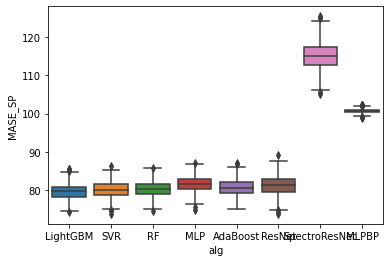

In [20]:
sns.boxplot(data=df_res_mase, x="alg", y="MASE_SP")
#plt.ylim(85,115)

In [63]:
def sign_diff_CI(df_mase, algs_, num = 1):
    lvls = [0.001,0.01,0.05]
    look = ['***','**','*']
    for i in range(len(algs_)):
        for j in range(i+1,len(algs_)):
            diff = df_mase[algs_[i]] - df_mase[algs_[j]]
            lvl = 'ns'
            show = False
            for sig, lvl_val in zip(lvls[:num], look[:num]):
                up = diff.quantile(1 - sig/2)
                low = diff.quantile(sig/2)
                if up*low > 0:
                    lvl = lvl_val
                    show = True
                    break
            if show: 
                print(algs_[i],algs_[j],lvl, [low,up])
                
algs_f2l = ['LightGBM','SVR','RF','MLP','AdaBoost']
algs_s2l = ['ResNet', 'SpectroResNet','MLPBP']
algs_s2s = ['U-Net','PPGIABP','VNet']
dbs = ['sensors','uci2','bcg','ppgbp']
algs_all = algs_f2l+algs_s2l+algs_s2s

ResNet SpectroResNet *** [-45.816879758062555, -22.71223791091329]
ResNet MLPBP *** [-26.804257546482127, -12.849741986889281]
SpectroResNet MLPBP *** [4.71549869369344, 25.001329581177927]


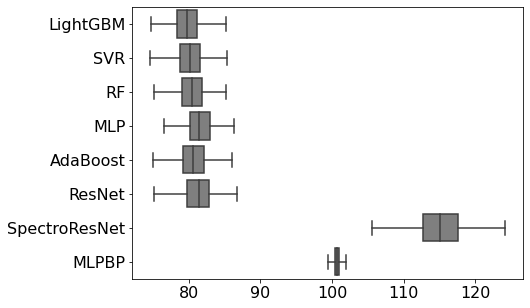

In [65]:
db = 'ppgbp'
tar = 'SP'
df_mase = pd.read_csv(f'results/{db}_{tar}.csv')
plt.figure(figsize=(7,5))
sns.boxplot(data=df_mase.sample(500), orient="h",boxprops={"facecolor": 'tab:grey'}, showfliers = False)
#plt.xlim(87,110)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot()
sign_diff_CI(df_mase, algs_f2l)
sign_diff_CI(df_mase, algs_s2l)
if 'ppgbp'!=db:
    sign_diff_CI(df_mase, algs_s2s)

LightGBM SVR *** [0.375049977972723, 2.0215068984082785]
LightGBM RF *** [-0.9625668236622621, -0.1350753437615091]
LightGBM MLP *** [-2.8220728723092594, -1.3321305217051216]
LightGBM AdaBoost *** [-1.453457742085981, -0.15152834416828226]
SVR RF *** [-2.6567469365214738, -0.9034649393245369]
SVR MLP *** [-4.114240221136264, -2.541502654486514]
SVR AdaBoost *** [-3.239458266345063, -1.1586759598821663]
RF MLP *** [-2.1225957358613368, -0.6478452299815424]
MLP AdaBoost *** [0.159896510339478, 2.297084217188987]
U-Net PPGIABP *** [-5.265435294651689, -2.788108008881713]
U-Net VNet *** [-13.59932406122142, -9.785278402003831]
PPGIABP VNet *** [-9.244340081467229, -5.995523377361746]


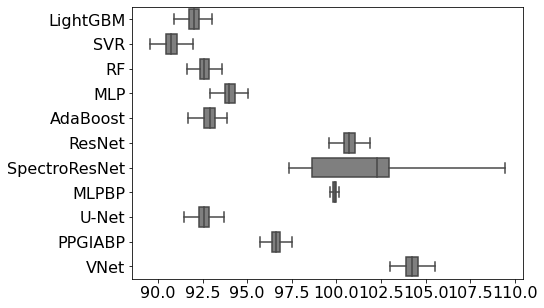

In [67]:
db = 'sensors'
tar = 'DP'
df_mase = pd.read_csv(f'results/{db}_{tar}.csv')
plt.figure(figsize=(7,5))
sns.boxplot(data=df_mase.sample(500), orient="h",boxprops={"facecolor": 'tab:grey'}, showfliers = False)
#plt.xlim(87,110)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot()
sign_diff_CI(df_mase, algs_f2l)
sign_diff_CI(df_mase, algs_s2l)
if 'ppgbp'!=db:
    sign_diff_CI(df_mase, algs_s2s)

## Generate MASE_SP and MASE_DP tables for each DBalgs_dic

In [142]:
algs_dic

{'lgb': 'LightGBM',
 'svr': 'SVR',
 'rf': 'RF',
 'mlp': 'MLP',
 'ada': 'AdaBoost',
 'resnet1d': 'ResNet',
 'spectroresnet': 'SpectroResNet',
 'mlpbp': 'MLPBP',
 'unet1d': 'U-Net',
 'ppgiabp': 'PPGIABP',
 'vnet': 'VNet'}

In [77]:
for db in dbs:
    df_res_mase = df_res[(df_res.db==db)][['alg','MASE_SP','MASE_DP']].reset_index(drop=True)
    df_res_mase['alg'] = df_res_mase.alg.map(lambda alg: algs_dic[alg])
    df_res_mase.to_csv(f'./results/{db}_mase.csv', index=False)

In [44]:
for db in dbs:
    for tar in ['SP','DP']:
        df_mase = df_res[df_res.db==db].pivot(index='samp',columns='alg', values=f'MASE_{tar}')
        if db == 'ppgbp':
            df_mase = df_mase[algs[:-3]].reset_index(drop=True)
            df_mase.columns = algs_cool[:-3]
        else:
            df_mase = df_mase[algs].reset_index(drop=True)
            df_mase.columns = algs_cool
        df_mase.to_csv(f'./results/{db}_{tar}.csv', index=False)

In [78]:
lgb = df_res[(df_res.db=='sensors') & (df_res.alg=='lgb')]['MASE_SP'].reset_index(drop=True)
svr = df_res[(df_res.db=='sensors') & (df_res.alg=='svr')]['MASE_SP'].reset_index(drop=True)
mlp = df_res[(df_res.db=='sensors') & (df_res.alg=='mlp')]['MASE_SP'].reset_index(drop=True)
ada = df_res[(df_res.db=='sensors') & (df_res.alg=='ada')]['MASE_SP'].reset_index(drop=True)

In [58]:
(lgb-svr).quantile(0.95), (lgb-svr).quantile(0.05)

(0.501079095498563, -0.22336182006234254)

In [60]:
(lgb-mlp).quantile(0.95), (lgb-mlp).quantile(0.05)

(-1.7974831300105145, -2.7460159815214475)

In [80]:
(lgb-ada).quantile(0.975), (lgb-ada).quantile(0.025)

(-0.41538436494703923, -1.0064041431292021)

In [51]:
df_res[(df_res.db=='sensors') & (df_res.alg=='lgb')]['MASE_SP'].reset_index(drop=True) - df_res[(df_res.db=='sensors') & (df_res.alg=='mlp')]['MASE_SP'].reset_index(drop=True)

0     -2.078241
1     -2.155631
2     -2.348247
3     -2.059835
4     -2.308551
         ...   
995   -2.039931
996   -2.325885
997   -2.598577
998   -2.457270
999   -2.125335
Name: MASE_SP, Length: 1000, dtype: float64

In [30]:
df_mase_sp[algs].reset_index(drop=True)

alg,lgb,svr,rf,mlp,ada,resnet1d,spectroresnet,mlpbp,unet1d,ppgiabp,vnet
0,88.914758,88.709965,90.192475,90.993000,89.797083,99.323484,95.845559,100.015559,88.780670,93.773402,95.215920
1,89.093018,89.092002,90.176729,91.248649,89.701495,99.120033,104.292654,100.295284,89.330921,93.673682,95.686011
2,89.449859,89.236631,90.638090,91.798106,89.929961,99.420322,121.356994,100.118764,89.244160,94.067652,95.012169
3,89.279145,88.842323,90.137783,91.338979,89.980907,99.581732,104.221812,100.373744,89.194337,93.840392,95.652775
4,88.210109,88.082972,89.749073,90.518660,88.810139,99.215343,103.479614,100.012048,88.254993,93.583335,95.171379
...,...,...,...,...,...,...,...,...,...,...,...
995,89.404900,89.222719,90.724321,91.444831,90.076166,99.564552,95.485569,99.957676,89.557635,94.177305,95.790107
996,88.176716,88.237802,89.582912,90.502601,88.657799,98.594754,103.227932,99.912824,88.211894,92.929505,94.866164
997,88.904085,88.650482,90.454562,91.502662,89.350769,99.006022,103.858938,100.004230,89.874762,94.027057,96.146681
998,88.856514,88.641165,90.103814,91.313784,89.486473,98.847748,95.528073,99.960282,88.735457,92.923153,95.204419


In [96]:
df_mase_sp

alg,ada,lgb,mlp,mlpbp,ppgiabp,resnet1d,rf,spectroresnet,svr,unet1d,vnet
samp,,,,,,,,,,,
0,89.797083,88.914758,90.993000,100.015559,93.773402,99.323484,90.192475,95.845559,88.709965,88.780670,95.215920
1,89.701495,89.093018,91.248649,100.295284,93.673682,99.120033,90.176729,104.292654,89.092002,89.330921,95.686011
2,89.929961,89.449859,91.798106,100.118764,94.067652,99.420322,90.638090,121.356994,89.236631,89.244160,95.012169
3,89.980907,89.279145,91.338979,100.373744,93.840392,99.581732,90.137783,104.221812,88.842323,89.194337,95.652775
4,88.810139,88.210109,90.518660,100.012048,93.583335,99.215343,89.749073,103.479614,88.082972,88.254993,95.171379
...,...,...,...,...,...,...,...,...,...,...,...
995,90.076166,89.404900,91.444831,99.957676,94.177305,99.564552,90.724321,95.485569,89.222719,89.557635,95.790107
996,88.657799,88.176716,90.502601,99.912824,92.929505,98.594754,89.582912,103.227932,88.237802,88.211894,94.866164
997,89.350769,88.904085,91.502662,100.004230,94.027057,99.006022,90.454562,103.858938,88.650482,89.874762,96.146681


# Friedmann

In [1]:
import mlflow as mf
from pathlib import Path
import itertools
import pandas as pd
import numpy as np
mf.set_tracking_uri(str(Path('../code/train/mlruns').absolute()))

algs = ['lgb', 'svr','rf','mlp','ada','resnet1d','spectroresnet','mlpbp','unet1d','ppgiabp','vnet']
tars = ['SP','DP']
mets = ['mae', 'me', 'std', 'mase']
mets2 = [i+'_'+j for i, j in itertools.product(tars, mets)]
dbs = ['sensors', 'uci2', 'bcg', 'ppgbp']

In [38]:
l_df= []
for db in dbs:
    df_metrics = pd.DataFrame(index=algs,columns=mets2)
    for alg in algs:
        if not(alg in ['resnet1d','spectroresnet','mlpbp','unet1d','ppgiabp','vnet']):
            for tar in tars:
                print(db, alg, tar)
                exp = mf.get_experiment_by_name(f'{db}-{alg}-{tar}')
                if not(exp is None):
                    runs = mf.search_runs([exp.experiment_id])
                    runs = runs[runs['tags.mlflow.parentRunId'].isnull()].reset_index(drop=True)
                    runs = runs[runs.status=='FINISHED'].reset_index(drop=True)
                    runs = runs[runs['tags.mlflow.source.name']=='train.py'].reset_index(drop=True)
                    if runs.shape[0] > 0:
                        cols1 = [tar+'_'+m for m in mets if m!='mase']
                        cols2 = ['metrics.ts/'+m for m in cols1]
                        df_metrics.loc[alg,cols1] = runs.iloc[0][cols2].values
                        df_metrics.loc[alg,f'{tar}_mase'] = runs.iloc[0][f'metrics.ts/{tar}_mae']/runs.iloc[0][f'metrics.nv/{tar}_mae'] *100
        else: 
            print(db, alg)
            exp = mf.get_experiment_by_name(f'{db}-{alg}')
            if not(exp is None):
                runs = mf.search_runs([exp.experiment_id])
                runs = runs[runs['tags.mlflow.parentRunId'].isnull()].reset_index(drop=True)
                runs = runs[runs.status=='FINISHED'].reset_index(drop=True)
                runs = runs[runs['tags.mlflow.source.name']=='train.py'].reset_index(drop=True)
                if runs.shape[0] > 0:
                    cols1 = [i+'_'+j for i, j in itertools.product(tars, mets) if j != 'mase']
                    cols2 = ['metrics.test/'+m.replace('SP','sbp').replace('DP','dbp') for m in cols1]
                    
                    df_metrics.loc[alg,cols1] = runs.iloc[0][cols2].values
                    df_metrics.loc[alg,f'SP_mase'] = runs.iloc[0][f'metrics.test/sbp_mae']/runs.iloc[0][f'metrics.nv/sbp_mae'] *100
                    df_metrics.loc[alg,f'DP_mase'] = runs.iloc[0][f'metrics.test/dbp_mae']/runs.iloc[0][f'metrics.nv/dbp_mae'] *100
    df_metrics['db'] = db
    l_df.append(df_metrics)
df_metrics = pd.concat(l_df)

sensors lgb SP
sensors lgb DP
sensors svr SP
sensors svr DP
sensors rf SP
sensors rf DP
sensors mlp SP
sensors mlp DP
sensors ada SP
sensors ada DP
sensors resnet1d
sensors spectroresnet
sensors mlpbp
sensors unet1d
sensors ppgiabp
sensors vnet
uci2 lgb SP
uci2 lgb DP
uci2 svr SP
uci2 svr DP
uci2 rf SP
uci2 rf DP
uci2 mlp SP
uci2 mlp DP
uci2 ada SP
uci2 ada DP
uci2 resnet1d
uci2 spectroresnet
uci2 mlpbp
uci2 unet1d
uci2 ppgiabp
uci2 vnet
bcg lgb SP
bcg lgb DP
bcg svr SP
bcg svr DP
bcg rf SP
bcg rf DP
bcg mlp SP
bcg mlp DP
bcg ada SP
bcg ada DP
bcg resnet1d
bcg spectroresnet
bcg mlpbp
bcg unet1d
bcg ppgiabp
bcg vnet
ppgbp lgb SP
ppgbp lgb DP
ppgbp svr SP
ppgbp svr DP
ppgbp rf SP
ppgbp rf DP
ppgbp mlp SP
ppgbp mlp DP
ppgbp ada SP
ppgbp ada DP
ppgbp resnet1d
ppgbp spectroresnet
ppgbp mlpbp
ppgbp unet1d
ppgbp ppgiabp
ppgbp vnet


In [44]:
df_metrics=df_metrics.apply(pd.to_numeric, errors='ignore')

In [46]:
df_metrics = df_metrics.reset_index()

In [47]:
df_metrics = df_metrics.rename(columns={'index':'alg'})

In [48]:
df_metrics

,alg,SP_mae,SP_me,SP_std,SP_mase,DP_mae,DP_me,DP_std,DP_mase,db
0,lgb,15.630,-0.047,19.635,88.761429,7.608,-0.017,9.818,92.039681,sensors
1,svr,15.605,-0.005,19.678,88.619456,7.502,-1.451,9.812,90.757319,sensors
2,rf,15.863,-0.117,19.848,90.084616,7.657,-0.034,9.864,92.632470,sensors
3,mlp,16.029,-0.498,20.100,91.027316,7.774,-0.194,10.039,94.047907,sensors
4,ada,15.752,-0.062,19.773,89.454256,7.680,-0.271,9.961,92.910719,sensors
5,resnet1d,17.459,-0.120,21.703,99.148163,8.329,-2.507,10.781,100.762158,sensors
6,spectroresnet,18.276,1.634,157.198,103.787836,8.461,0.396,36.223,102.359061,sensors
7,mlpbp,17.615,0.014,21.860,100.034073,8.258,-0.021,10.509,99.903218,sensors
8,unet1d,15.640,-1.156,19.641,88.818218,7.656,-0.448,9.929,92.620373,sensors
9,ppgiabp,16.446,-3.233,20.411,93.395423,7.988,-0.310,10.280,96.636826,sensors
